# Tarefa 1: Fazer classificação de Barney e Homer utilizando extração de características

## Etapa 1: Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch
from skorch import NeuralNetClassifier
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import os

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(42)
np.random.seed(42)

## Etapa 2: Base de dados

## Etapa 3: Definição do modelo

## Etapa 4: Treinamento do modelo

# Tarefa 2: Treinando rede para o Cifar10 com Validação cruzada

## Etapa 1: Importação das bibliotecas

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torchvision import datasets, transforms
from google.colab import drive

drive.mount('/content/drive')

torch.manual_seed(42)
np.random.seed(42)

Mounted at /content/drive


## Etapa 2: Base de dados

In [ ]:
dataset = datasets.CIFAR10(root='./data', train=True, download=True)

previsores = dataset.data
classe = dataset.targets

type(previsores), type(classe)

100%|██████████| 170M/170M [00:05<00:00, 32.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


(numpy.ndarray, list)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


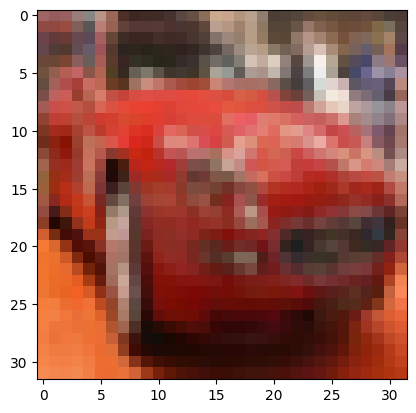

In [ ]:
plt.imshow(previsores[5])

In [ ]:
nome_classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
classe[5]

1

In [ ]:
classe = np.array(classe)

In [ ]:
previsores.shape, classe.shape

((50000, 32, 32, 3), (50000,))

In [ ]:
data_train, data_test, target_train, target_test = train_test_split(previsores, classe, test_size=0.20, random_state=42, stratify=classe)

In [ ]:
np.unique(target_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]))

In [ ]:
data_train = torch.tensor(np.array(data_train), dtype=torch.float)
target_train = torch.tensor(np.array(target_train), dtype=torch.long)
data_test = torch.tensor(np.array(data_test), dtype=torch.float)
target_test = torch.tensor(np.array(target_test), dtype=torch.long)

dataset_train = torch.utils.data.TensorDataset(data_train, target_train)
dataset_test = torch.utils.data.TensorDataset(data_test, target_test)

## Etapa 3: Definição do modelo

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)
    self.bn5 = nn.BatchNorm2d(128)
    self.bn6 = nn.BatchNorm2d(128)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(in_features=128*4*4, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.output = nn.Linear(in_features=256, out_features=10)

    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.pool(x) # 32 / 2 = 16
    x = self.dropout(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.activation(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.activation(x)
    x = self.pool(x) # 16 / 2 = 8
    x = self.dropout(x)

    x = self.conv5(x)
    x = self.bn5(x)
    x = self.activation(x)
    x = self.conv6(x)
    x = self.bn6(x)
    x = self.activation(x)
    x = self.pool(x) # 16 / 2 = 4
    x = self.dropout(x)

    x = self.flatten(x)

    x = self.fc1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.output(x)

    return x

## Etapa 4: Treinamento do modelo

In [ ]:
k_folds = 3
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_train)):
    print(f'Treinando Fold {fold+1}/{k_folds}')

    train_data = torch.utils.data.Subset(dataset_train, train_idx)
    val_data = torch.utils.data.Subset(dataset_train, val_idx)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 50
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        for inputs, labels in train_loader:
            inputs = inputs.permute(0, 3, 1, 2).float().to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        running_loss /= len(train_loader)

        model.eval()
        correct, total, val_loss = 0, 0, 0.
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.permute(0, 3, 1, 2).float().to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Calcular perda na validação
                val_loss += loss.item()  # Somar perda
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()


        val_loss /= len(val_loader)
        val_accuracy = correct / len(val_data)

        print(f"Fold {fold+1}: Epoch {epoch+1:2d}/{epochs} | Loss: {running_loss:.4f} | Val_Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
     # Após treinar o modelo...
    torch.save(model.state_dict(), f"/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep Learning com PyTorch/CNN Models/modelo_cnn{fold}.pth")



Treinando Fold 1/3
Fold 1: Epoch  1/50 | Loss: 1.5483 | Val_Loss: 1.3489 | Val Accuracy: 0.4928
Fold 1: Epoch  2/50 | Loss: 1.1607 | Val_Loss: 1.2404 | Val Accuracy: 0.5763
Fold 1: Epoch  3/50 | Loss: 0.9713 | Val_Loss: 1.0209 | Val Accuracy: 0.6308
Fold 1: Epoch  4/50 | Loss: 0.8557 | Val_Loss: 0.8078 | Val Accuracy: 0.7131
Fold 1: Epoch  5/50 | Loss: 0.7710 | Val_Loss: 0.8807 | Val Accuracy: 0.7053
Fold 1: Epoch  6/50 | Loss: 0.7065 | Val_Loss: 0.7693 | Val Accuracy: 0.7344
Fold 1: Epoch  7/50 | Loss: 0.6452 | Val_Loss: 0.7555 | Val Accuracy: 0.7365
Fold 1: Epoch  8/50 | Loss: 0.6026 | Val_Loss: 0.6713 | Val Accuracy: 0.7706
Fold 1: Epoch  9/50 | Loss: 0.5691 | Val_Loss: 0.6316 | Val Accuracy: 0.7752
Fold 1: Epoch 10/50 | Loss: 0.5229 | Val_Loss: 0.6230 | Val Accuracy: 0.7831
Fold 1: Epoch 11/50 | Loss: 0.4985 | Val_Loss: 0.6333 | Val Accuracy: 0.7896
Fold 1: Epoch 12/50 | Loss: 0.4554 | Val_Loss: 0.6338 | Val Accuracy: 0.7885
Fold 1: Epoch 13/50 | Loss: 0.4332 | Val_Loss: 0.6113 | V

# Etapa 5: Avaliação do modelo

Avaliar e construir matriz de confusão:

<ipython-input-18-f8990b44e7c1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep L

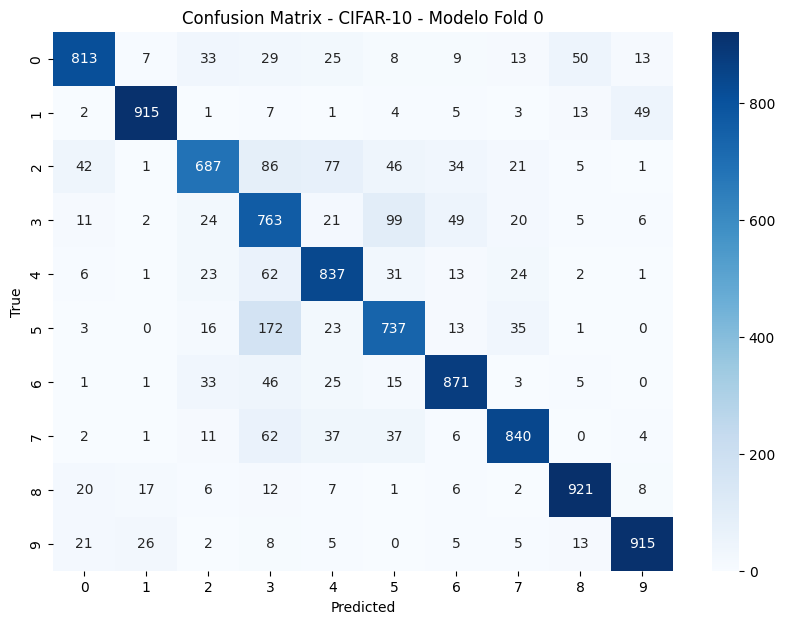

<ipython-input-18-f8990b44e7c1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep L

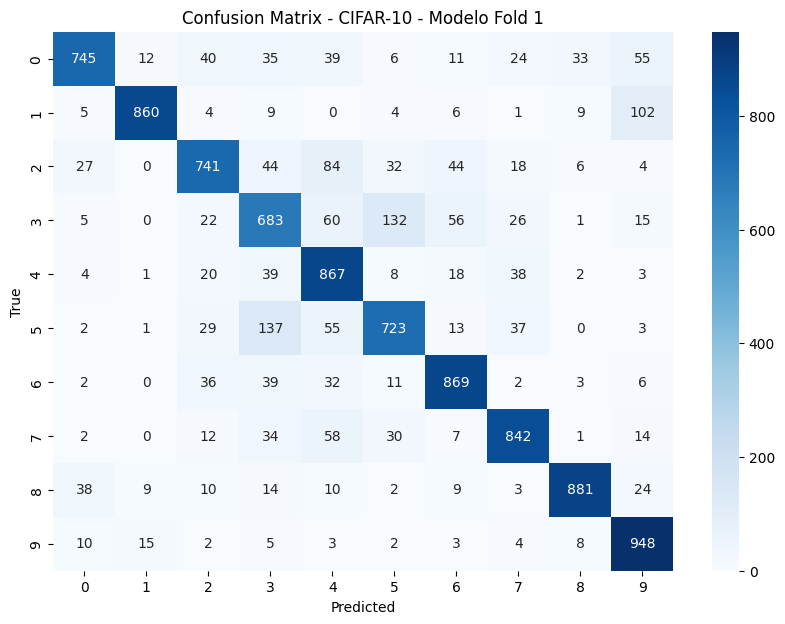

<ipython-input-18-f8990b44e7c1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep L

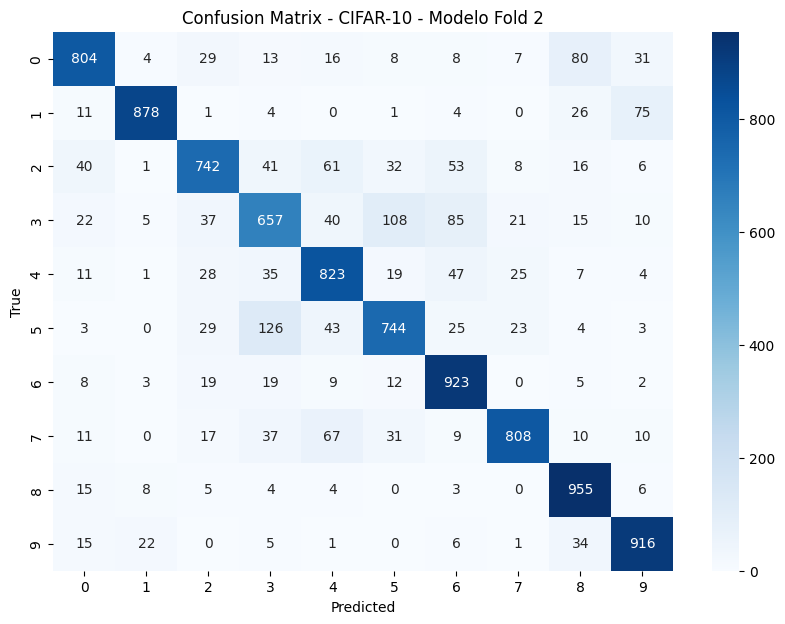

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False)

k_folds = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold in range(k_folds):
  model = CNN().to(device)
  model.load_state_dict(torch.load(f'/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep Learning com PyTorch/CNN Models/modelo_cnn{fold}.pth'))
  model.eval()

  all_preds = []
  all_labels = []

  model.eval()
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.permute(0, 3, 1, 2).float().to(device)
          labels = labels.to(device)

          # Inferência
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Gerar matriz de confusão
  cm = confusion_matrix(all_labels, all_preds)

  # Plotando a matriz de confusão
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nome_classes, yticklabels=nome_classes)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix - CIFAR-10 - Modelo Fold {fold}')
  plt.show()

